In [25]:
!apt-get update
!apt-get install ffmpeg libsm6 libxext6 -y
!python -m pip install opencv-python

python is /usr/local/bin/python


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten ,Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import numpy as np
import os 
import random
import cv2
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
#from sklearn.model_selection import train_test_split

In [7]:
rootDir = './animals-dataset'
trainingDir = rootDir + '/training'

In [23]:
def load_data(path):
    foldernames = os.listdir(path)
    images = []
    labels = []
    for k, folder in enumerate(foldernames):
        files = os.listdir(path + '/' + folder)
        for i, file in enumerate(files):
            img = cv2.imread(path + '/' + folder + '/' + file)
            labels.append(folder)
            images.append(img)
    return (images, labels)

In [24]:
(training_images, trainig_labels) = load_data(trainingDir)

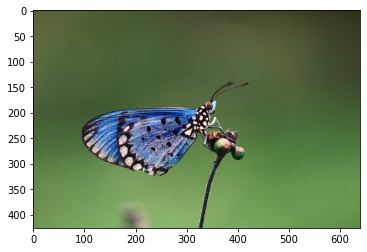

In [25]:
plt.imshow(training_images[0])

In [26]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  trainingDir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)


Found 5000 files belonging to 10 classes.
Using 4000 files for training.
['butterflies', 'cats', 'chicken', 'cows', 'dogs', 'elefants', 'horses', 'sheeps', 'spider', 'squirrel']
